In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
diabetes_df = pd.read_csv("diabetes.csv")  # Diabetes dataset
heart_df = pd.read_csv("heart.csv")  # Heart Disease dataset
kidney_df = pd.read_csv("kidney_disease.csv")  # Kidney Disease dataset

In [4]:
# Display first few rows to understand dataset structures
print("Diabetes Dataset:\n", diabetes_df.head(), "\n")
print("Heart Disease Dataset:\n", heart_df.head(), "\n")
print("Kidney Disease Dataset:\n", kidney_df.head(), "\n")

Diabetes Dataset:
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1   

Heart Disease Dataset:
    age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1

In [5]:
# Add a column to indicate disease type
diabetes_df["Disease"] = "Diabetes"
heart_df["Disease"] = "Heart Disease"
kidney_df["Disease"] = "Kidney Disease"

In [23]:
# Standardize column names for consistency across datasets
diabetes_df.rename(columns={'BloodPressure': 'bp', 'Glucose': 'glucose', 'Age': 'age'}, inplace=True)
heart_df.rename(columns={'trestbps': 'bp', 'age': 'age'}, inplace=True)
kidney_df.rename(columns={'bp': 'bp', 'age': 'age', 'bgr': 'glucose', 'classification': 'target'}, inplace=True)

In [24]:
# Select common features that exist across all datasets
common_features = ['age', 'bp', 'glucose']  # Features available in all datasets

In [25]:
# Ensure only available features are used in each dataset
diabetes_features = list(set(common_features) & set(diabetes_df.columns))
heart_features = list(set(common_features) & set(heart_df.columns))
kidney_features = list(set(common_features) & set(kidney_df.columns))

In [26]:
# Drop rows with missing values only for available features
diabetes_df = diabetes_df.dropna(subset=diabetes_features)
heart_df = heart_df.dropna(subset=heart_features)
kidney_df = kidney_df.dropna(subset=kidney_features)

print("Missing values dropped successfully!")


Missing values dropped successfully!


In [27]:
# Merge datasets based on available features
df = pd.concat([
    diabetes_df[diabetes_features + ["Disease"]],
    heart_df[heart_features + ["Disease"]],
    kidney_df[kidney_features + ["Disease"]]
], ignore_index=True)

In [28]:
# Display merged dataset
print("\nMerged Dataset:\n", df.head())


Merged Dataset:
      bp  glucose   age   Disease
0  72.0    148.0  50.0  Diabetes
1  66.0     85.0  31.0  Diabetes
2  64.0    183.0  32.0  Diabetes
3  66.0     89.0  21.0  Diabetes
4  40.0    137.0  33.0  Diabetes


In [36]:
# Filter out features that are completely missing in one or more disease groups
valid_features = [feature for feature in common_features if df.groupby("Disease")[feature].count().min() > 0]

In [29]:
# Check for zero variance before applying ANOVA
for feature in common_features:
    variance = df.groupby("Disease")[feature].var()
    print(f"Variance for {feature}:\n{variance}\n")

Variance for age:
Disease
Diabetes          138.303046
Heart Disease      82.484558
Kidney Disease    240.525108
Name: age, dtype: float64

Variance for bp:
Disease
Diabetes          374.647271
Heart Disease     307.586453
Kidney Disease    190.279368
Name: bp, dtype: float64

Variance for glucose:
Disease
Diabetes          1022.248314
Heart Disease             NaN
Kidney Disease    6246.592148
Name: glucose, dtype: float64



In [37]:
# Perform ANOVA only on valid features
anova_results = {}
for feature in valid_features:
    groups = [df[df["Disease"] == disease][feature].dropna() for disease in df["Disease"].unique()]
    if all(len(group) > 1 for group in groups):  # Ensure each disease has enough values
        f_stat, p_value = stats.f_oneway(*groups)
        anova_results[feature] = {"F-statistic": f_stat, "p-value": p_value}
    else:
        anova_results[feature] = {"F-statistic": np.nan, "p-value": np.nan}  # Not enough data

In [44]:
# Convert ANOVA results to DataFrame
anova_df = pd.DataFrame(anova_results).T
print("\nANOVA Results for Interrelation Between Diseases:\n", anova_df)


ANOVA Results for Interrelation Between Diseases:
      F-statistic        p-value
age   481.797918  3.869286e-160
bp   1387.295576   0.000000e+00


In [45]:
# Interpret ANOVA Results
for feature, result in anova_results.items():
    if result["p-value"] < 0.05:
        print(f"✅ {feature}: Statistically significant difference across diseases (p-value = {result['p-value']:.5f})")
    else:
        print(f"⚠ {feature}: No significant difference (p-value = {result['p-value']:.5f})")

✅ age: Statistically significant difference across diseases (p-value = 0.00000)
✅ bp: Statistically significant difference across diseases (p-value = 0.00000)


In [46]:
print("Available columns in merged dataset:", df.columns)
print("Glucose values per disease:\n", df.groupby("Disease")["glucose"].count())


Available columns in merged dataset: Index(['bp', 'glucose', 'age', 'Disease'], dtype='object')
Glucose values per disease:
 Disease
Diabetes          768
Heart Disease       0
Kidney Disease    340
Name: glucose, dtype: int64


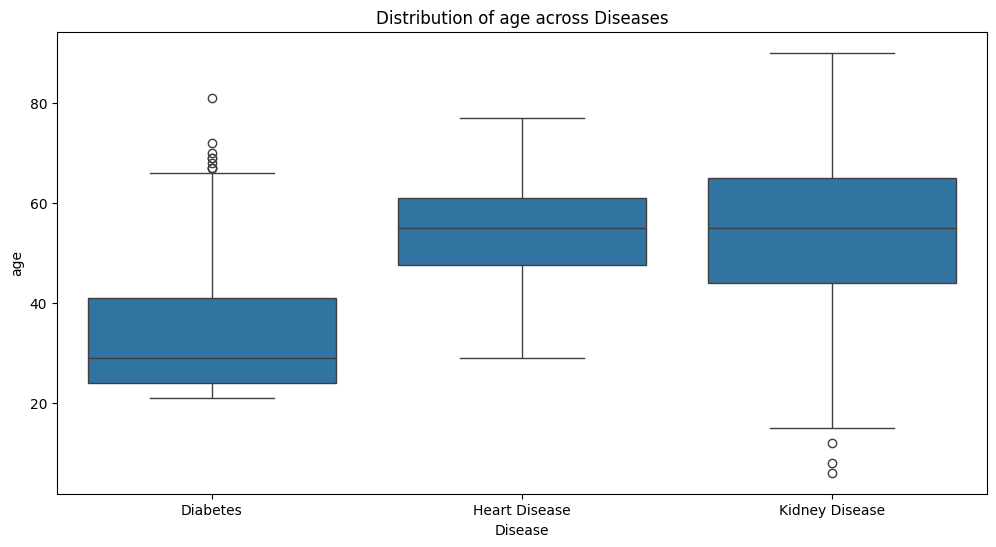

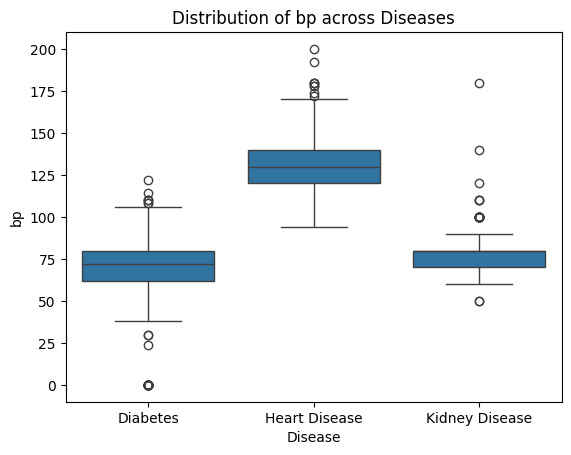

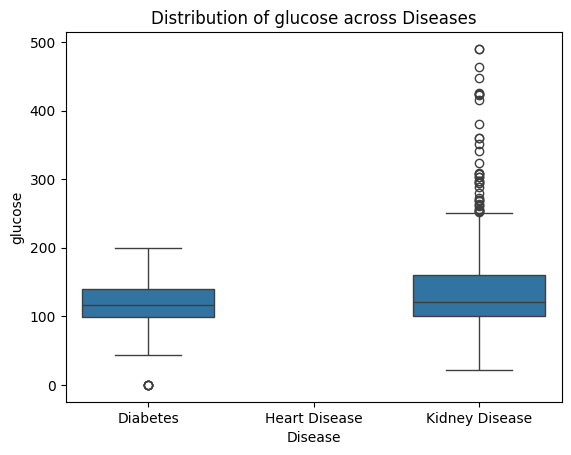

In [47]:
# Visualize feature distributions across diseases
plt.figure(figsize=(12, 6))
for feature in common_features:
    if feature in df.columns:  # Ensure feature exists before plotting
        sns.boxplot(x="Disease", y=feature, data=df)
        plt.title(f"Distribution of {feature} across Diseases")
        plt.show()